# Tumor microenvironment (TME) deconvolution

## Introduction

Tumor microenvironment [TME] effects are a major confounder in any dataset of tumor DNA methylation. Differences in methylation between tumor and normal cells or between different tumors can just reflect a different proportion of immune or cancer associated fibroblasts (CAF) cells. Fortunately, the METABRIC dataset contains gene expression for each sample, which allows us to identify Immune and CAF expression signatures and associate them with those of DNA methylation, using the cross-correlations between gene expression profiles with promoter methylation signatures. 

In broad strokes, _Methylayer_'s normalization strategy is to:

1. Compute cross-correlation between gene expression and promoter methylation. 
2. Cluster the cross-correlation matrix to identify TME expression signatures (i.e. groups of TME genes that affect promoter methylation). 
3. Use the Euclidean distance in the 2D space of these signatures to identify the K-nearest neighbors of each tumor. 
4. Subtract from the raw methylation value of each tumor the mean methylation of its K neighbors.

More details regarding TME normalization can be found in the Methylayer R package: https://github.com/tanaylab/methylayer

See also __Supplementary Note 1__ for an additional, independent and unsupervised analysis scheme using non-negative matrix factorization (NMF) that further validated Methylayer estimates of Immune and CAF.

## Initialize

In [1]:
source(here::here("scripts/init.R"))

## Load data

#### Promoter methylation matrix:

In [2]:
prom_avg_meth <- fread(here("data/promoter_avg_meth_filt.csv")) %>% 
    select(-name, -name3.chr) %>% 
    distinct(chrom, start, end, .keep_all = TRUE) %>% 
    as_tibble()
head(prom_avg_meth)
dim(prom_avg_meth)

chrom start  end    MB_0006     MB_0028    MB_0030    MB_0035    MB_0040   
1 chr1  762469 763020 0.000000000 0.00000000 0.00000000 0.00000000 0.00000000
2 chr1  762676 763227 0.021929825 0.03018109 0.07858546 0.00000000 0.01627486
3 chr1  860619 861170 0.001870324 0.01188300 0.01046622 0.15767196 0.01549464
4 chr1  895465 896016 0.014367816 0.04901961 0.04769737 0.03629032 0.03182580
5 chr1  901375 901926 0.024253731 0.05357143 0.02334630 0.01470588 0.01798561
6 chr1  948345 948896 0.000000000 0.00000000 0.00000000 0.02083333 0.00000000
  MB_0046    MB_0050    ⋯ MB_7281    MB_7283    MB_7285    MB_7288    
1 0.00000000 0.00000000 ⋯ 0.00000000 0.01829268         NA 0.000000000
2 0.21922626 0.02072539 ⋯ 0.02374169 0.17092338 0.01785714 0.000000000
3 0.05299539 0.01040583 ⋯ 0.01910480 0.00802139 0.02392344 0.002307692
4 0.06606607 0.01002506 ⋯ 0.03778802 0.04700855 0.11333333 0.004689332
5 0.00000000 0.02662722 ⋯ 0.10212766 0.04149378 0.01369863 0.000000000
6 0.00000000         NA ⋯ 0.00000000 0.02439024 0.00000000 0.009523810
  MB_7289     MB_7291    MB_7292    MB_7293     MB_7296    MB_7298    
1 0.000000000 0.00000000 0.00000000 0.006849315         NA 0.000000000
2 0.066974596 0.00000000 0.11016949 0.042925278 0.01030928 0.062780269
3 0.002057613 0.01895375 0.02185792 0.000000000 0.00000000 0.006283229
4 0.030204962 0.02810651 0.14285714 0.026392962 0.09826590 0.058666667
5 0.015873016 0.07216495 0.07185629 0.021526419 0.00000000 0.029490617
6 0.010309278 0.00000000 0.00000000 0.000000000 0.00000000 0.000000000

[1] 15693  1785

#### Expression matrix: 

In [3]:
expr_mat <- fread(here("data/expression_matrix.csv")) %>% expr_intervs_to_mat()
head(expr_mat)
dim(expr_mat)

MB_0362  MB_0346  MB_0386  MB_0574  MB_0185  MB_0503  MB_0641 
A1BG     5.607785 5.515704 5.581684 5.602209 5.560794 5.443726 5.374949
A1BG-AS1       NA       NA       NA       NA       NA       NA       NA
A1CF     5.409415 5.652667 5.364459 5.378185 5.485144 5.321734 5.386645
A2M      7.653319 6.564312 8.201633 7.587296 8.427318 7.545219 8.693606
A2M-AS1        NA       NA       NA       NA       NA       NA       NA
A2ML1    5.535317 5.938013 5.337279 5.221707 5.514548 5.279701 5.201008
         MB_0201  MB_0218  MB_0316  ⋯ MB_1036  MB_1116  MB_1044   MB_1049  
A1BG     5.625163 5.533212 5.359228 ⋯ 5.225141 5.303794  5.490734  5.494082
A1BG-AS1       NA       NA       NA ⋯       NA       NA        NA        NA
A1CF     5.432328 5.332541 5.493423 ⋯ 5.428412 5.474348  5.419358  5.700195
A2M      8.898809 8.763382 9.100264 ⋯ 9.198370 9.042949 10.144846 10.143342
A2M-AS1        NA       NA       NA ⋯       NA       NA        NA        NA
A2ML1    5.695971 5.108838 6.942946 ⋯ 5.366756 5.799424  5.139738  5.095827
         MB_1068  MB_0812  MB_1076  MB_0814  MB_1087  MB_0822  
A1BG     5.269375 5.468187 5.566886 5.433821 5.320485  5.502541
A1BG-AS1       NA       NA       NA       NA       NA        NA
A1CF     5.478201 5.752783 5.673940 5.862117 5.424626  5.791611
A2M      9.782934 8.360063 9.929925 9.927135 9.638372 10.153996
A2M-AS1        NA       NA       NA       NA       NA        NA
A2ML1    5.545775 5.608514 5.503125 5.350733 5.267158  5.455640

[1] 26245  2124

Note that we matched promoter methylation and gene expression profiles using Refseq annotations. Alternative promoters were resolved by selecting the promoter with the minimal average methylation value in the normal samples.

#### Genomic methylation:

After we use the promoter methylation and expression to deconvolute the data, we can remove the TME signatures also from the genomic regions. We need, therefore, do load also the entire avg. methylation dataset (both promoter and genomic):

In [4]:
genomic_avg_meth <- fread(here("data/genomic_msp1_avg_meth_filt.csv")) %>% as_tibble()
all_meth <- bind_rows(
    prom_avg_meth, 
    genomic_avg_meth
)

head(all_meth)
dim(all_meth)

chrom start  end    MB_0006     MB_0028    MB_0030    MB_0035    MB_0040   
1 chr1  762469 763020 0.000000000 0.00000000 0.00000000 0.00000000 0.00000000
2 chr1  762676 763227 0.021929825 0.03018109 0.07858546 0.00000000 0.01627486
3 chr1  860619 861170 0.001870324 0.01188300 0.01046622 0.15767196 0.01549464
4 chr1  895465 896016 0.014367816 0.04901961 0.04769737 0.03629032 0.03182580
5 chr1  901375 901926 0.024253731 0.05357143 0.02334630 0.01470588 0.01798561
6 chr1  948345 948896 0.000000000 0.00000000 0.00000000 0.02083333 0.00000000
  MB_0046    MB_0050    ⋯ MB_7281    MB_7283    MB_7285    MB_7288    
1 0.00000000 0.00000000 ⋯ 0.00000000 0.01829268         NA 0.000000000
2 0.21922626 0.02072539 ⋯ 0.02374169 0.17092338 0.01785714 0.000000000
3 0.05299539 0.01040583 ⋯ 0.01910480 0.00802139 0.02392344 0.002307692
4 0.06606607 0.01002506 ⋯ 0.03778802 0.04700855 0.11333333 0.004689332
5 0.00000000 0.02662722 ⋯ 0.10212766 0.04149378 0.01369863 0.000000000
6 0.00000000         NA ⋯ 0.00000000 0.02439024 0.00000000 0.009523810
  MB_7289     MB_7291    MB_7292    MB_7293     MB_7296    MB_7298    
1 0.000000000 0.00000000 0.00000000 0.006849315         NA 0.000000000
2 0.066974596 0.00000000 0.11016949 0.042925278 0.01030928 0.062780269
3 0.002057613 0.01895375 0.02185792 0.000000000 0.00000000 0.006283229
4 0.030204962 0.02810651 0.14285714 0.026392962 0.09826590 0.058666667
5 0.015873016 0.07216495 0.07185629 0.021526419 0.00000000 0.029490617
6 0.010309278 0.00000000 0.00000000 0.000000000 0.00000000 0.000000000

[1] 201082   1785

## Deconvolve TME 

Due to the very different characteristics of ER+/ER- and normal samples, we analyze them separatly. 

`k` is chosen based on the number of samples in the dataset. See below a power analysis on the effect of K on normalization. 

We exclude loci with mean methylation value lower than 0.1 or higher than 0.9 (`min_meth`, `max_meth`) and use only rows (expression profiles) and columns (methylation profiles) that have at least one correlation value greater than 0.25 or smaller than -0.25 (`meth_cor_thresh`, `expr_cor_thresh`). 

We use "CD3D" gene as an anchor for immune genes, and "CAV1" as an anchor for CAF genes. 

The following utility function subsets samples from the methylation matrices and then runs `methylayer::deconv_TME`:

In [5]:
deconv_TME_metabric <- function(prom_avg_meth, all_meth, expr_mat, samples, ...){
    prom_mat <- prom_avg_meth %>% select(chrom:end, any_of(samples)) %>% intervs_to_mat()
    raw_meth_mat <- all_meth %>% select(chrom:end, any_of(samples)) %>% intervs_to_mat()
    res <- methylayer::deconv_TME(prom_mat, expr_mat, raw_meth_mat, ...)
    return(res)
}

### ER+ samples

In [6]:
ER_positive_norm_meth <- deconv_TME_metabric(prom_avg_meth, all_meth, expr_mat, ER_positive_samples, k = 30) %cache_rds% here("data/ER_positive_norm_meth.rds")

min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



### ER- samples

In [7]:
ER_negative_norm_meth <- deconv_TME_metabric(prom_avg_meth, all_meth, expr_mat, ER_negative_samples, k = 15) %cache_rds% here("data/ER_negative_norm_meth.rds")

min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



### Normal samples

In [8]:
normal_norm_meth <- deconv_TME_metabric(prom_avg_meth, all_meth, expr_mat, normal_samples, k = 15) %cache_rds% here("data/normal_norm_meth.rds")

min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



### Merge normalized methylation

For convenience, we can now merge the TME-normalized methylation from ER+/ER-/normal samples to a single file:

In [9]:
all_norm_meth <- 
    cbind(ER_positive_norm_meth$norm_meth, ER_negative_norm_meth$norm_meth, normal_norm_meth$norm_meth) %>% 
    mat_to_intervs() %cache_df% 
    here("data/all_norm_meth.tsv") %>% 
    as_tibble()
dim(all_norm_meth)

[1] 201082   1513

### Merge TME scores 

We also merge the CAF and Immmune score for each sample. Note that `methylayer` extracts both the expression module score (`caf` and `immune` columns) and methylation score (`caf.meth`, `immune.meth`). The expression scores were used for the deconvolution wheareas the methylation scores are the average methylation of the loci that were correlated to the expression score (above 0.3, `scores_cor_thresh` parameter). 

In [10]:
tme_df <- bind_rows(
        ER_positive_norm_meth$tme_features,
        ER_negative_norm_meth$tme_features,
        normal_norm_meth$tme_features
    ) %>%            
    select(samp, caf, immune, caf.meth, immune.meth) %cache_df% 
    here("data/TME_features.tsv") %>% 
    as_tibble()
tme_df

samp    caf        immune      caf.meth  immune.meth
1    MB_0006 -0.2441946 -0.11148374 0.2950609 0.4722494  
2    MB_0028 -1.7266095 -0.93589443 0.4851022 0.6191494  
3    MB_0046 -0.6545081 -1.00235816 0.4210078 0.6308352  
4    MB_0050  1.7038169  0.12816401 0.2336145 0.4808316  
5    MB_0053 -0.8152407  0.21037289 0.4603347 0.5915159  
6    MB_0054 -0.5608747  0.92928291 0.4790603 0.6093489  
7    MB_0064 -1.2425410 -1.15791942 0.3917584 0.6194888  
8    MB_0068  0.1582690 -0.28702359 0.3530527 0.5844362  
9    MB_0112  0.5506982  0.22289111 0.4618399 0.5806044  
10   MB_0113  0.2430250 -0.35434081 0.4100261 0.5298153  
11   MB_0114 -0.6750266 -0.95721438 0.4307791 0.6331123  
12   MB_0119 -1.2109712  0.19548251 0.4886685 0.6028845  
13   MB_0120 -0.1563293  0.88096016 0.5453498 0.6014958  
14   MB_0121 -0.3576126 -0.26019057 0.4695825 0.5758571  
15   MB_0123 -0.1229211 -0.38340480 0.5086341 0.7029203  
16   MB_0124  1.3159516  0.83505659 0.3894070 0.5970664  
17   MB_0125 -1.3927749 -1.28470712 0.4993262 0.6927743  
18   MB_0126 -0.2081013 -0.53204316 0.2492417 0.4671965  
19   MB_0127  1.0798815  0.04720652 0.1843968 0.2068975  
20   MB_0128  2.0881634  1.34218096 0.2846881 0.4232669  
21   MB_0130  0.7209482 -0.09325291 0.3910930 0.5327711  
22   MB_0131 -0.7581783 -0.54694377 0.4395017 0.5820976  
23   MB_0133  1.3324760 -0.77573398 0.3181587 0.5313431  
24   MB_0134 -0.6130295 -0.78380356 0.2902577 0.5096654  
25   MB_0135 -0.7906420 -0.19429441 0.6089456 0.6340680  
26   MB_0136  0.5399103  1.37950243 0.2933684 0.4342144  
27   MB_0138  1.0505373 -0.22183072 0.2848923 0.5065305  
28   MB_0140 -0.2713810 -0.34600080 0.5987273 0.6977136  
29   MB_0142 -0.9139848 -1.34756822 0.6183344 0.7392434  
30   MB_0143 -0.7358840 -0.36531127 0.4174192 0.4404964  
⋮    ⋮       ⋮          ⋮           ⋮         ⋮          
1481 MB_1075 -0.2894873 -0.04419236 0.4302952 0.4616980  
1482 MB_1076  0.9238830 -1.32376482 0.3855511 0.4915135  
1483 MB_1077 -1.4246008  0.48053085 0.5664800 0.3710155  
1484 MB_1080 -0.7820633  0.87793279 0.5056884 0.4248678  
1485 MB_1081  0.1793551 -0.11510331 0.4225939 0.5083196  
1486 MB_1082  0.5927439 -0.33338110 0.4549526 0.4536039  
1487 MB_1085  1.4163636 -1.28804949 0.3026138 0.5838570  
1488 MB_1086  1.5539001 -1.84579369 0.3267837 0.5621724  
1489 MB_1087  1.8787832 -2.32021896 0.2953830 0.5785214  
1490 MB_1096  0.7961008 -0.66715720 0.4258531 0.5025420  
1491 MB_1100 -0.4434748  0.66938958 0.4200541 0.4609012  
1492 MB_1103 -1.2166704  0.75510892 0.5923372 0.3810320  
1493 MB_1104 -1.2855527  1.11030115 0.4915558 0.3904465  
1494 MB_1105 -0.2027432  0.80397063 0.4667859 0.4384329  
1495 MB_1107 -0.2954456  0.38208707 0.4177748 0.5127786  
1496 MB_1111  1.7919504 -2.15978940 0.3086540 0.5246932  
1497 MB_1114 -0.7689965  0.95817405 0.5025200 0.3854280  
1498 MB_1116  0.4234887 -0.17389280 0.4634448 0.4280609  
1499 MB_1120 -0.6246282  0.80861410 0.4019885 0.3932106  
1500 MB_1121 -0.3238614  0.38059752 0.3568351 0.5124807  
1501 MB_1122  1.8534849 -1.73008221 0.3473962 0.4867064  
1502 MB_1124  0.1224931 -0.12290403 0.3289584 0.5010873  
1503 MB_1125  1.7806069 -1.82214015 0.2509303 0.5291079  
1504 MB_1126  1.7099300 -1.99146058 0.2738257 0.5421860  
1505 MB_1127  1.7072531 -2.06452569 0.3492059 0.5177611  
1506 MB_1129  0.8618067 -0.47232115 0.5199767 0.3653358  
1507 MB_1130  1.4313162 -2.12062343 0.2745858 0.5612103  
1508 MB_1131  1.8157536 -2.11992873 0.2570782 0.5494308  
1509 MB_1132  0.3500557 -0.26968242 0.3609761 0.5195122  
1510 MB_1134  1.3075984 -1.36609707 0.4092366 0.4637476

### CAF and Immune genes

We can see the genes that were used in the deconvolution by running `get_TME_genes` function: 

In [11]:
get_TME_genes(ER_positive_norm_meth$em_cross_clust, caf_gene = NULL)

[1] "ACAP1"     "ADA"       "ADAM7"     "AIM2"      "AOAH"      "APBB1IP"  
  [7] "APOBEC3G"  "ARHGAP30"  "ARHGAP4"   "ARHGAP9"   "ARRDC5"    "BANK1"    
 [13] "BIRC3"     "BLK"       "BTLA"      "BTN3A1"    "BTN3A2"    "BTN3A3"   
 [19] "C1orf162"  "CAMK1G"    "CCL13"     "CCL5"      "CCR2"      "CCR7"     
 [25] "CD19"      "CD2"       "CD247"     "CD27"      "CD28"      "CD37"     
 [31] "CD38"      "CD3D"      "CD3E"      "CD3G"      "CD40"      "CD40LG"   
 [37] "CD48"      "CD5"       "CD52"      "CD53"      "CD6"       "CD69"     
 [43] "CD7"       "CD79A"     "CD8A"      "CD96"      "CORO1A"    "CST7"     
 [49] "CTSH"      "CTSS"      "CTSW"      "CXCL13"    "CXCR3"     "CXCR5"    
 [55] "CXCR6"     "CYBB"      "CYTIP"     "DHRS9"     "DOCK11"    "DOCK2"    
 [61] "DOCK8"     "DOK2"      "DPEP2"     "EBI3"      "EOMES"     "EVI2B"    
 [67] "FAM65B"    "FCAR"      "FCN1"      "FCRLA"     "FERMT3"    "FGD2"     
 [73] "FGL2"      "FGR"       "FLT3LG"    "FOXN2"     "GAB3"      "GBP2"     
 [79] "GFI1"      "GPR18"     "GPR183"    "GZMA"      "GZMB"      "GZMH"     
 [85] "GZMK"      "HAPLN3"    "HLA-DMA"   "HLA-DOA"   "HLA-DQA1"  "HLA-E"    
 [91] "HSD11B1"   "HVCN1"     "IGLL1"     "IGLL3P"    "IL10RA"    "IL15"     
 [97] "IL16"      "IL18BP"    "IL18RAP"   "IL2RB"     "IL2RG"     "IL32"     
[103] "IRF8"      "ITGB2"     "ITK"       "JSRP1"     "KLHL6"     "KLRD1"    
[109] "KLRG1"     "LAMP3"     "LAX1"      "LCK"       "LCP1"      "LGALS2"   
[115] "LPXN"      "LY9"       "LY96"      "LYN"       "MAP4K1"    "MAPK1"    
[121] "MATK"      "MEI1"      "MGAT1"     "MS4A6A"    "NAPSA"     "NAPSB"    
[127] "NCF4"      "NFS1"      "NKG7"      "NPSR1"     "P2RY10"    "P2RY8"    
[133] "PARVG"     "PLAC8"     "PLCB2"     "PLEK"      "PLEKHA2"   "PLEKHO1"  
[139] "PNOC"      "POU2AF1"   "PRF1"      "PSMB10"    "PSTPIP1"   "PTGDS"    
[145] "PTPN22"    "PTPN7"     "PTPRCAP"   "PVRIG"     "PYHIN1"    "RAB33A"   
[151] "RAC2"      "RASAL3"    "RASGRP2"   "RASGRP3"   "RCSD1"     "RGL4"     
[157] "RHOG"      "S1PR4"     "SAMD3"     "SASH3"     "SEL1L3"    "SELL"     
[163] "SH2D1A"    "SH3BGRL3"  "SIRPG"     "SLA2"      "SLAMF1"    "SLAMF6"   
[169] "SPIB"      "SPOCK2"    "SRGN"      "STK17B"    "SYK"       "TBC1D10C" 
[175] "TCN2"      "THEMIS"    "TLR8"      "TLR9"      "TMEM140"   "TNFAIP3"  
[181] "TNFAIP8"   "TNFRSF13B" "TNFRSF17"  "TNFRSF1B"  "TNFSF14"   "TOX2"     
[187] "TRAT1"     "UBASH3A"   "VAMP5"     "VCAM1"     "VPREB3"    "WAS"      
[193] "WIPF1"     "ZAP70"     "ZNF831"

In [12]:
message("ER+")
get_TME_genes(ER_positive_norm_meth$em_cross_clust, caf_gene = NULL) %>% length()
get_TME_genes(ER_positive_norm_meth$em_cross_clust, immune_gene = NULL) %>% length()

ER+



[1] 195

[1] 207

In [13]:
message("ER-")
get_TME_genes(ER_negative_norm_meth$em_cross_clust, caf_gene = NULL) %>% length()
get_TME_genes(ER_negative_norm_meth$em_cross_clust, immune_gene = NULL) %>% length()

ER-



[1] 345

[1] 360

In [14]:
message("normal")
get_TME_genes(normal_norm_meth$em_cross_clust, caf_gene = NULL) %>% length()
get_TME_genes(normal_norm_meth$em_cross_clust, immune_gene = NULL) %>% length()

normal



[1] 864

[1] 592

## Expression-methylation correlation matrices

`methylayer` allows us to plot the expression-methylation correlation matrices it uses in the deconvolution process: 

#### Extended Data Figure 2a-b

plotting em cross



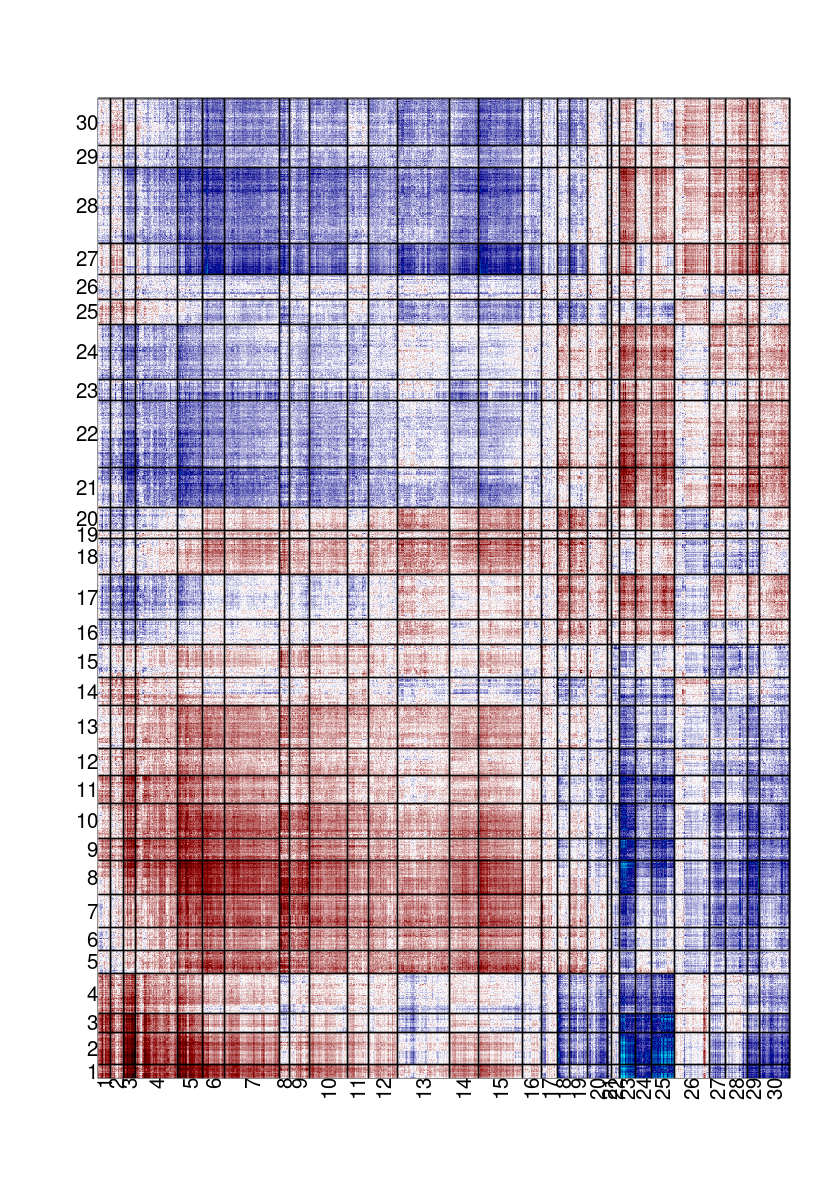

In [15]:
options(repr.plot.width = 7, repr.plot.height=10)
methylayer::plot_em_cross_cor(ER_positive_norm_meth$em_cross_clust)

In [16]:
dim(ER_positive_norm_meth$em_cross_clust$em_cross)

[1] 2701 5879

plotting em cross



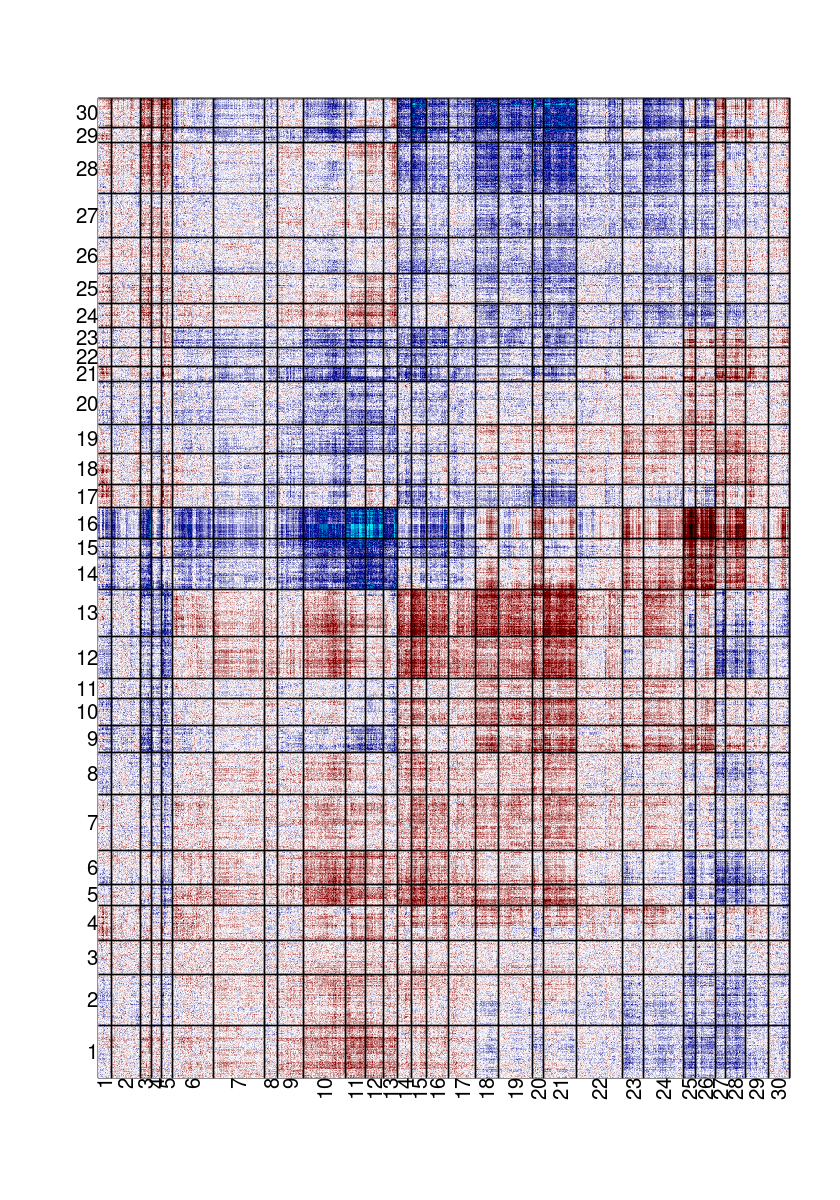

In [17]:
options(repr.plot.width = 7, repr.plot.height=10)
plot_em_cross_cor(ER_negative_norm_meth$em_cross_clust)

In [18]:
dim(ER_negative_norm_meth$em_cross_clust$em_cross)

[1]  3525 11054

plotting em cross



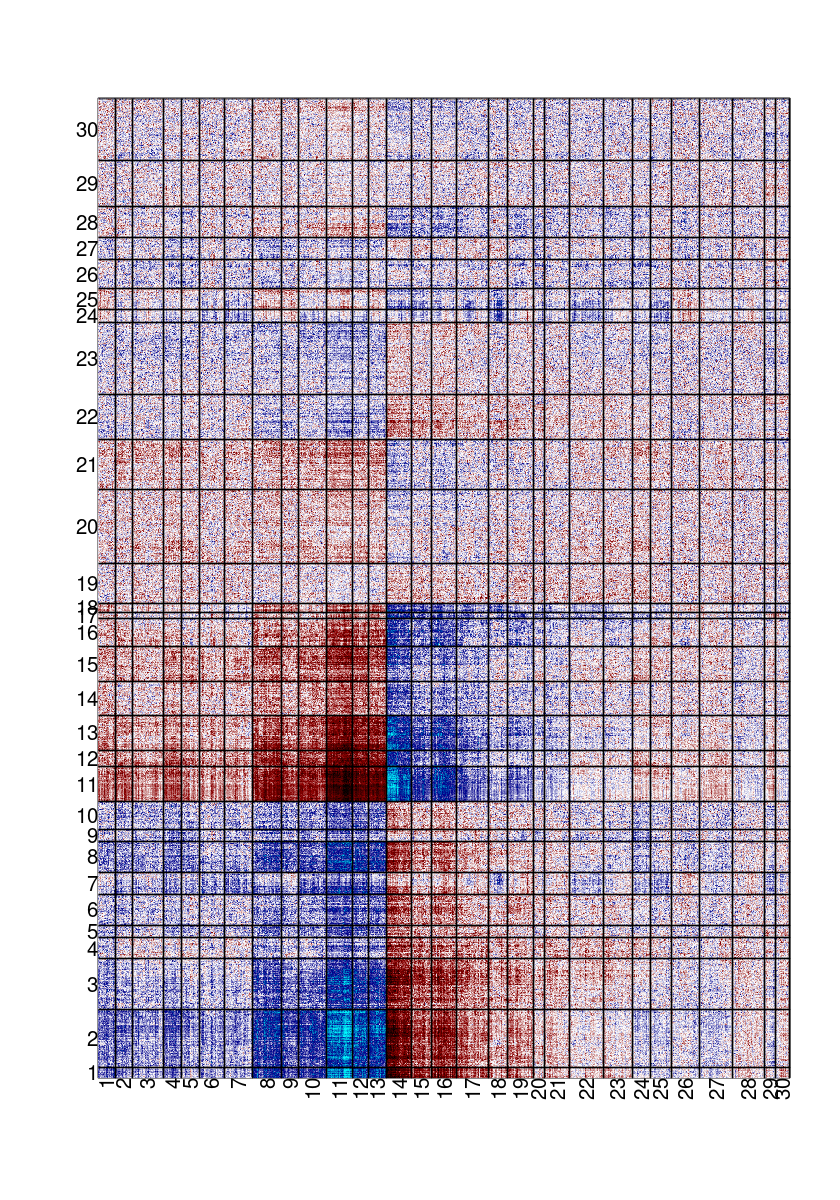

In [19]:
options(repr.plot.width = 7, repr.plot.height=10)
plot_em_cross_cor(normal_norm_meth$em_cross_clust)

In [20]:
dim(normal_norm_meth$em_cross_clust$em_cross)

[1]  2636 16806

### Export clustering

We can export summary statistics (centers) of the expression-methylation clusters to excel files:

In [21]:
methylayer::export_em_cross_mods(ER_negative_norm_meth$em_cross_clust, here("export", "em_cross_ER_negative.xlsx"))
methylayer::export_em_cross_mods(ER_positive_norm_meth$em_cross_clust, here("export", "em_cross_ER_positive.xlsx"))
methylayer::export_em_cross_mods(normal_norm_meth$em_cross_clust, here("export", "em_cross_normal.xlsx"))

## Diagnose TME normalization

We will extract the correlation of the raw and normalized methylation to gene expression of selected genes in order to see that our normalization worked. 

In [22]:
before_after_df <- methylayer::calc_gene_cor_before_after_deconv(
    ER_positive_norm_meth, 
    all_meth, 
    c("CAV1", "CD3D", "GATA3", "TOP2A")) %cache_df% 
    here("data/gene_cor_before_after_ER_positive.tsv") %>% 
    as_tibble()

In [23]:
before_after_df <- before_after_df %>% 
    select(-ends_with(".norm")) %>% 
    gather("gene", "cor_raw", -(chrom:end)) %>% 
    left_join(before_after_df %>% 
              select(chrom:end, ends_with(".norm")) %>% 
              gather("gene", "cor_norm", -(chrom:end)) %>% 
              mutate(gene = gsub(".norm$", "", gene)), by = c("chrom", "start", "end", "gene"))

#### Figure 1h

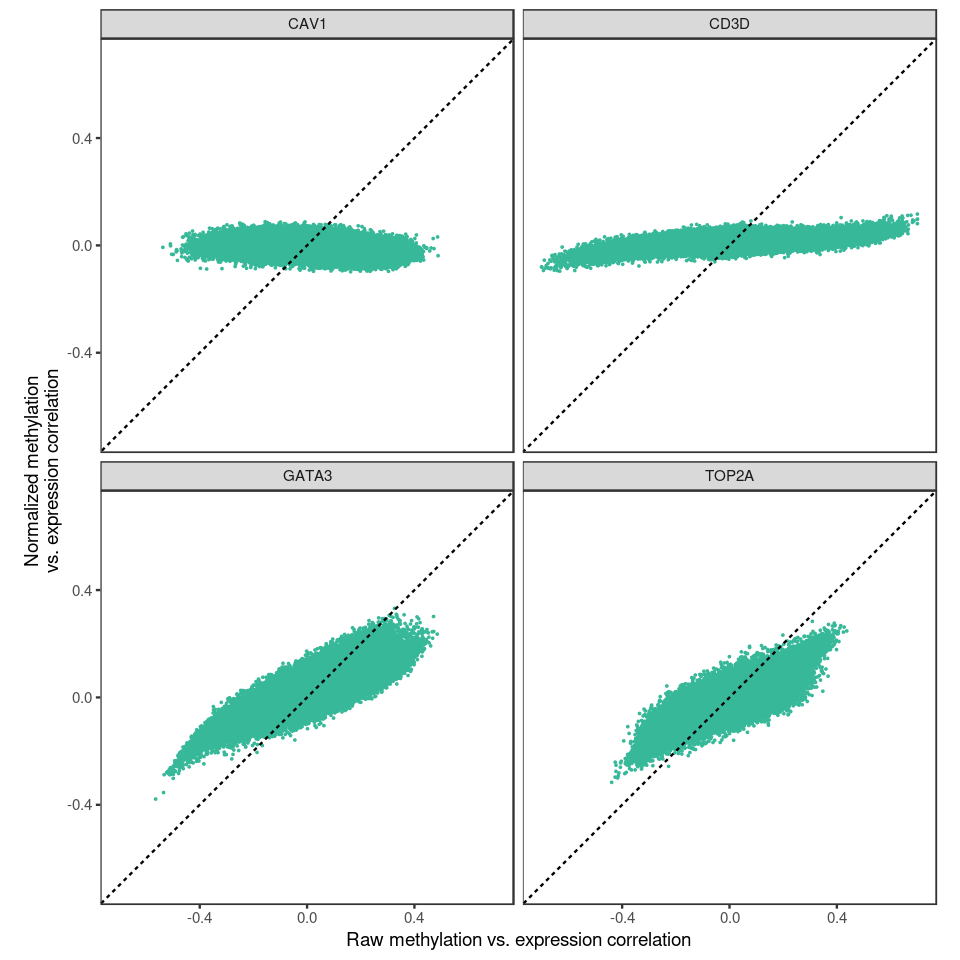

In [24]:
options(repr.plot.width = 8, repr.plot.height = 8)

lims <- c(-0.7, 0.7)

p_before_after <- before_after_df %>% 
    mutate(ER = "ER+") %>%     
    mutate(
            cor_raw = tgutil::clip_vals(cor_raw, lims[1], lims[2]),
            cor_norm = tgutil::clip_vals(cor_norm, lims[1], lims[2])
        ) %>% 
    ggplot(aes(x=cor_raw, y=cor_norm, color=ER)) + 
        geom_point(size=0.001) + 
        scale_color_manual(values=annot_colors$ER1) + 
        geom_abline(linetype = "dashed") + 
        xlab("Raw methylation vs. expression correlation") +
        ylab("Normalized methylation\nvs. expression correlation") +
        facet_wrap(.~gene, nrow=2) + 
        guides(color="none") + 
        xlim(lims[1], lims[2]) +
        ylim(lims[1], lims[2]) +
        theme(aspect.ratio=1) + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

p_before_after + theme_bw() + theme(aspect.ratio=1) + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

We plot the CAF and immune expression signatures against the promoter that is most anti-correlated with CD3D gene expression:

In [25]:
get_top_cor_promoter <- function(gene, em_cross){
    em_cross[, gene] %>% 
        as.matrix() %>% 
        mat_to_intervs() %>% 
        rename(cor = V1) %>% 
        inner_join(promoter_intervs, by = c("chrom", "start", "end")) %>% 
        arrange(cor) %>% 
        slice(1) %>% 
        as_tibble()
}

In [26]:
get_locus_before_after_meth <- function(deconv_list, raw_meth, intervals){
    raw_meth <- all_meth %>% 
        inner_join(intervals, by = c("chrom", "start", "end")) %>% 
        gather("samp", "raw_meth", -(chrom:end)) %>% 
        as_tibble()
    norm_meth <- deconv_list$norm_meth[intervals %>% intervs_to_mat() %>% rownames(), ]  %>% 
        enframe("samp", "norm_meth") %>% 
        as_tibble()
    return(raw_meth %>% left_join(norm_meth, by = "samp"))
}

In [27]:
plot_before_after_gene_cor_meth <- function(gene, tme_df, deconv_list, raw_meth){
    anti_cor_gene <- get_top_cor_promoter(gene, deconv_list$em_cross$em_cross)
before_after_meth <- get_locus_before_after_meth(deconv_list, raw_meth, anti_cor_gene %>% select(chrom, start, end)) %>% add_ER()
    p_gene_norm_before_after <- tme_df %>% 
        left_join(before_after_meth, by = "samp") %>% 
        filter(ER == "ER+") %>% 
        select(samp, CAF=caf, Immune=immune, `Methylation`=raw_meth, `Normalized\nMethylation`=norm_meth) %>% 
        gather("type", "meth", -samp, -Immune, -CAF) %>% 
        mutate(type = factor(type, levels=c("Methylation", "Normalized\nMethylation"))) %>% 
        gather("expr_type", "expr", -samp, -type, -meth) %>% 
        ggplot(aes(x=meth, y=expr)) + 
            geom_point(size=0.1) + 
            facet_grid(expr_type~type, scales="free_x") + 
            theme(aspect.ratio=1) + xlab("")  + 
            ylab("Expression") + 
            scale_y_continuous(labels = scales::number_format(accuracy = 0.1)) + 
            ggtitle(glue("{anti_cor_gene$name[1]} ({gene})")) + vertical_labs()
    p_gene_norm_before_after
}

#### Extended Data Figure 3a-d

Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


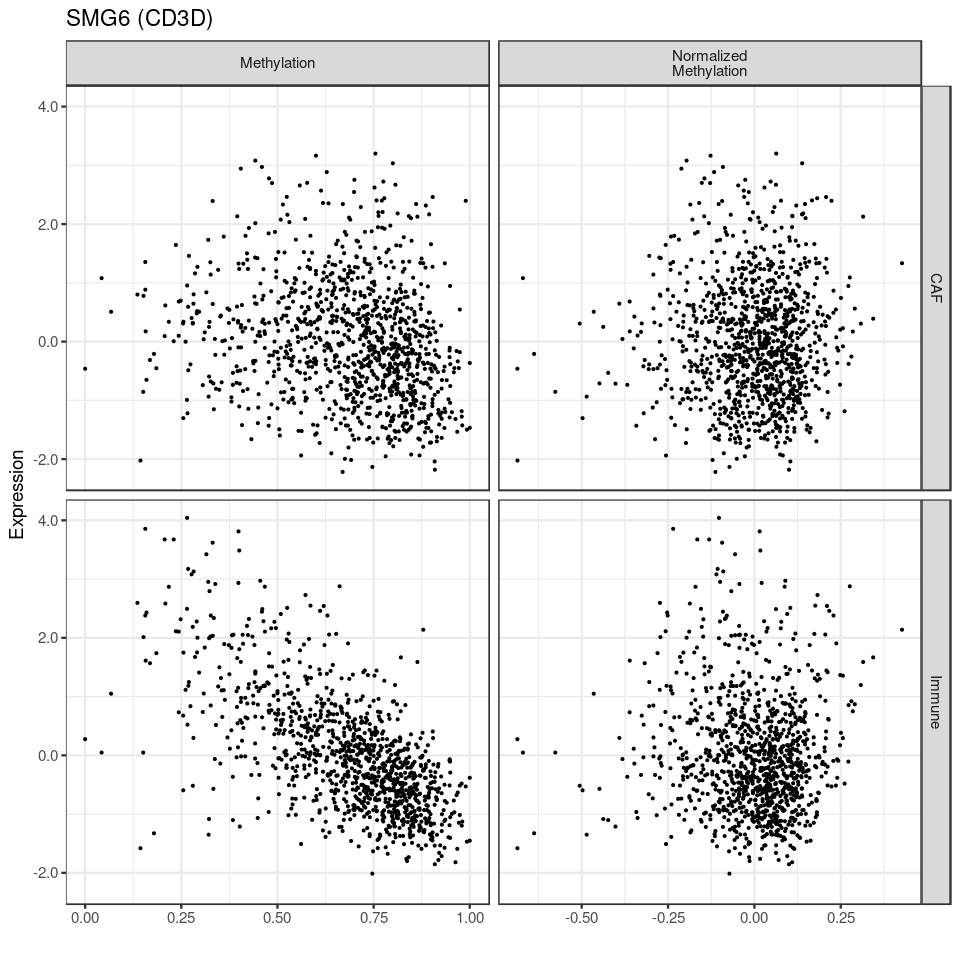

Warning message:
“Removed 84 rows containing missing values (geom_point).”


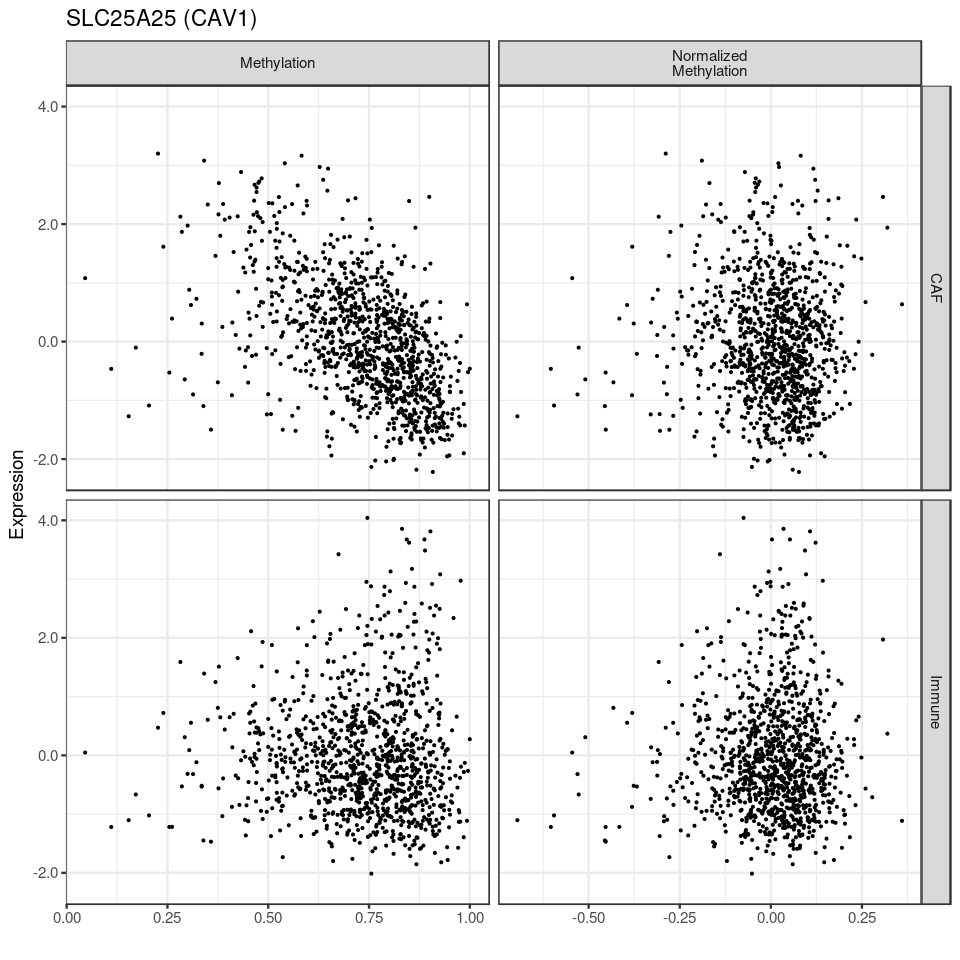

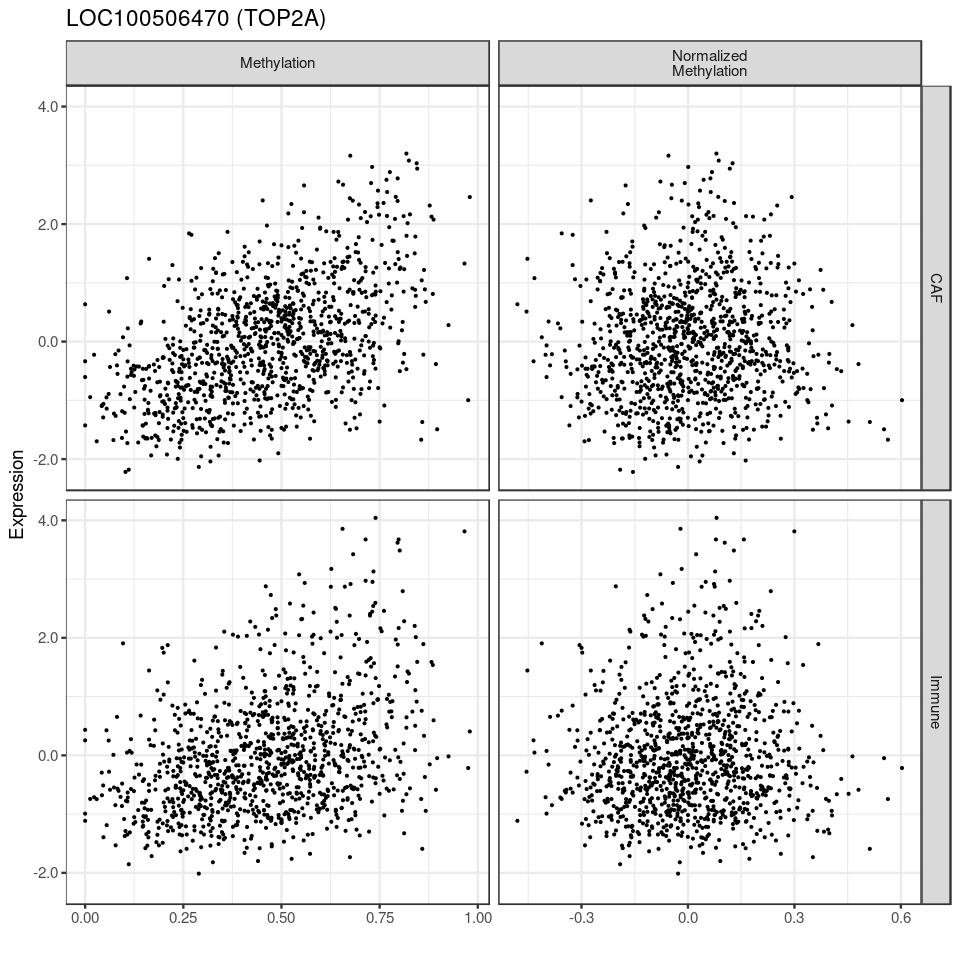

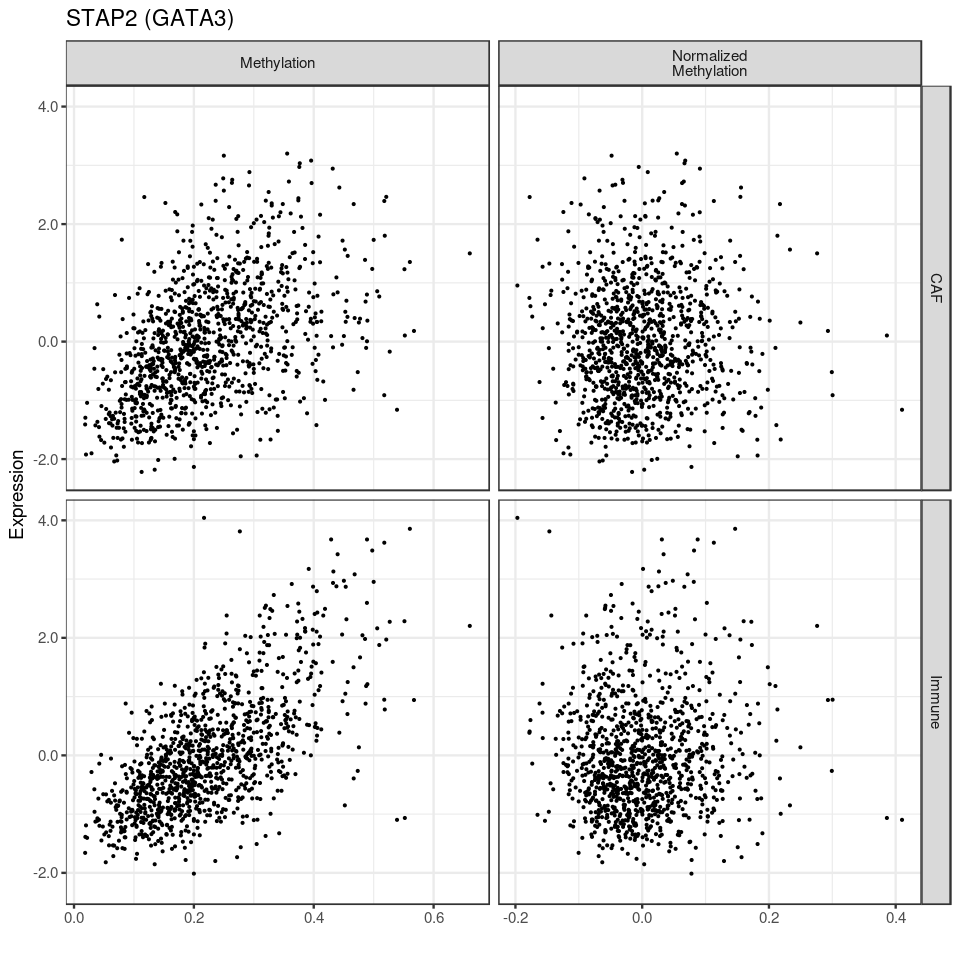

In [28]:
p_cd3d_top_meth <- plot_before_after_gene_cor_meth("CD3D", tme_df, ER_positive_norm_meth, all_meth)
p_cav1_top_meth <- plot_before_after_gene_cor_meth("CAV1", tme_df, ER_positive_norm_meth, all_meth)
p_top2a_top_meth <- plot_before_after_gene_cor_meth("TOP2A", tme_df, ER_positive_norm_meth, all_meth)
p_gata3_top_meth <- plot_before_after_gene_cor_meth("GATA3", tme_df, ER_positive_norm_meth, all_meth)

p_cd3d_top_meth + theme_bw()
p_cav1_top_meth + theme_bw()
p_top2a_top_meth + theme_bw()
p_gata3_top_meth + theme_bw()

## Plot CD3D and CAV1 vs immune and CAF methylation modules

#### Figure 1f

Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


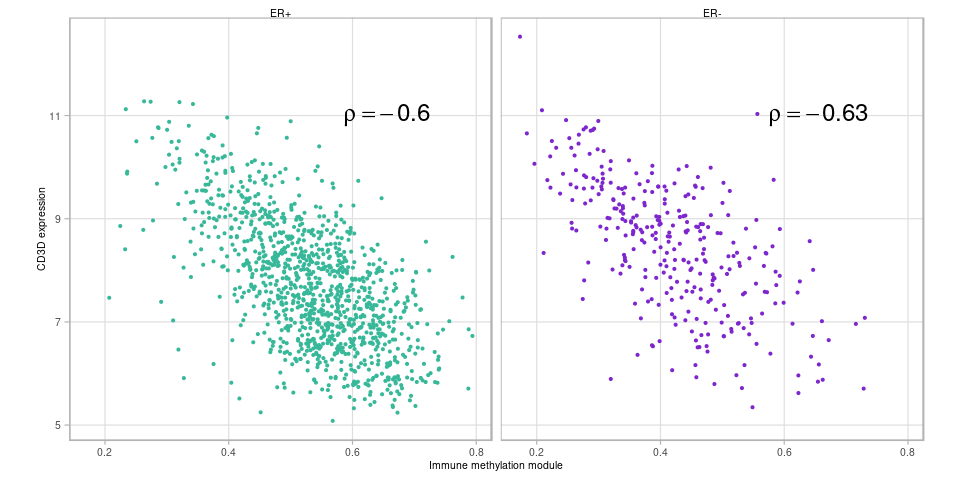

In [29]:
options(repr.plot.width = 8, repr.plot.height = 4)

df <- tme_df %>%     
    add_ER() %>% 
    left_join(expr_mat["CD3D", ] %>% 
    enframe("samp", "expr")) %>% 
    filter(ER != "normal") %>%     
    as_tibble() 
    
rho_df <- df %>% 
    group_by(ER) %>% 
    summarise(rho = cor(immune.meth, expr, use="pairwise.complete.obs", method="spearman")) %>% 
    mutate(label = sprintf("~rho == %0.2f", rho))


p_CD3D <- df %>% 
    ggplot(aes(x=immune.meth, y=expr, color=ER)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values=annot_colors$ER1) + 
        theme(aspect.ratio=1) + 
        guides(color=FALSE) + 
        facet_wrap(.~ER) + 
        xlab("Immune methylation module") + 
        ylab("CD3D expression")        

p_CD3D + geom_text(data = rho_df, inherit.aes = FALSE, x = 0.65, y = 11, aes(label=label), parse=TRUE, size=5)

Joining, by = "samp"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


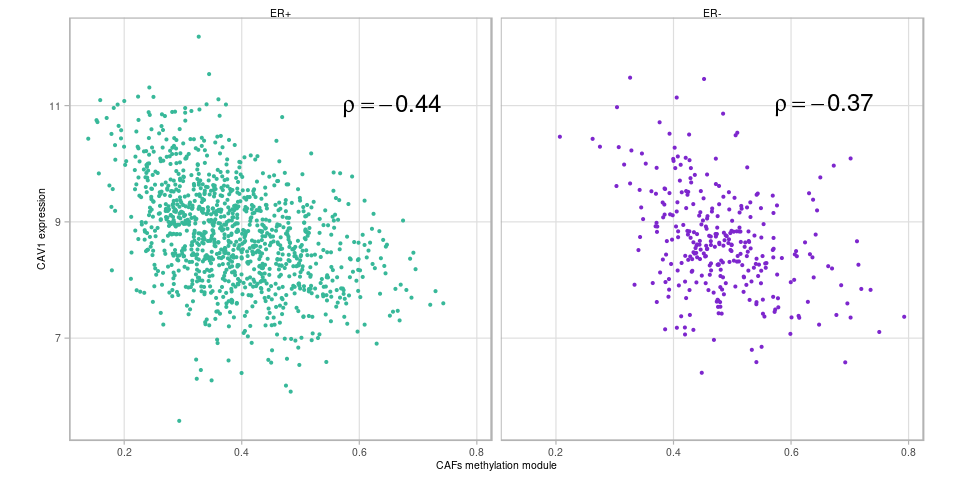

In [30]:
options(repr.plot.width = 8, repr.plot.height = 4)

df <- tme_df %>%     
    add_ER() %>% 
    left_join(expr_mat["CAV1", ] %>% 
    enframe("samp", "expr")) %>% 
    filter(ER != "normal") %>%     
    as_tibble() 
    
rho_df <- df %>% 
    group_by(ER) %>% 
    summarise(rho = cor(caf.meth, expr, use="pairwise.complete.obs", method="spearman")) %>% 
    mutate(label = sprintf("~rho == %0.2f", rho))


p_CAV1 <- df %>% 
    ggplot(aes(x=caf.meth, y=expr, color=ER)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values=annot_colors$ER1) + 
        theme(aspect.ratio=1) + 
        guides(color=FALSE) + 
        facet_wrap(.~ER) + 
        xlab("CAFs methylation module") + 
        ylab("CAV1 expression") 
       

p_CAV1 + geom_text(data = rho_df, inherit.aes = FALSE, x = 0.65, y = 11, aes(label=label), parse=TRUE, size=5)

#### Extended Data Figure 2c

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


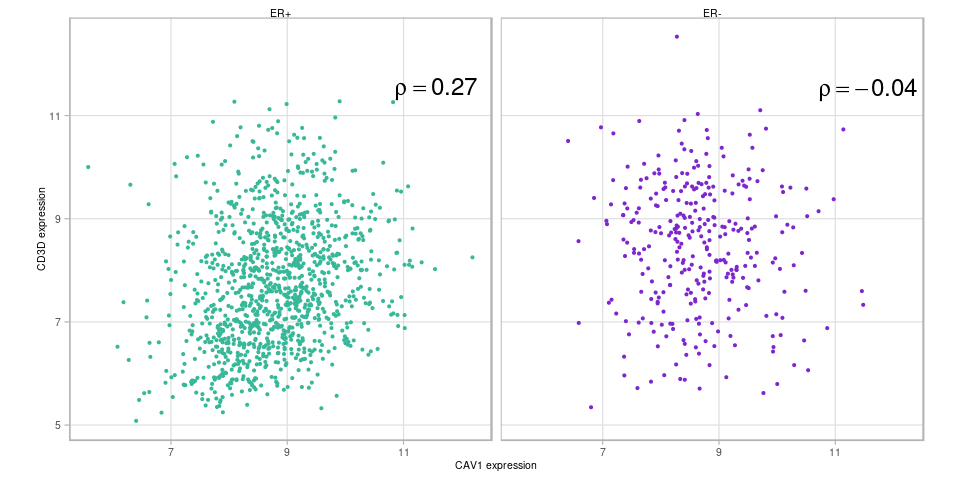

In [31]:
options(repr.plot.width = 8, repr.plot.height = 4)

df <- expr_mat[c("CAV1", "CD3D"), ] %>% t() %>% as.data.frame() %>% rownames_to_column("samp") %>% as_tibble() %>% add_ER() %>% filter(ER != "normal")
    
rho_df <- df %>% 
    group_by(ER) %>% 
    summarise(rho = cor(CAV1, CD3D, use="pairwise.complete.obs", method="spearman")) %>% 
    mutate(label = sprintf("~rho == %0.2f", rho))


p_CAV1_CD3D <- df %>% 
    ggplot(aes(x=CAV1, y=CD3D, color=ER)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values=annot_colors$ER1) + 
        theme(aspect.ratio=1) + 
        guides(color="none") + 
        facet_wrap(.~ER) + 
        xlab("CAV1 expression") + 
        ylab("CD3D expression") 
        

p_CAV1_CD3D + geom_text(data = rho_df, inherit.aes = FALSE, x = 11.5, y = 11.5, aes(label=label), parse=TRUE, size=5)

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


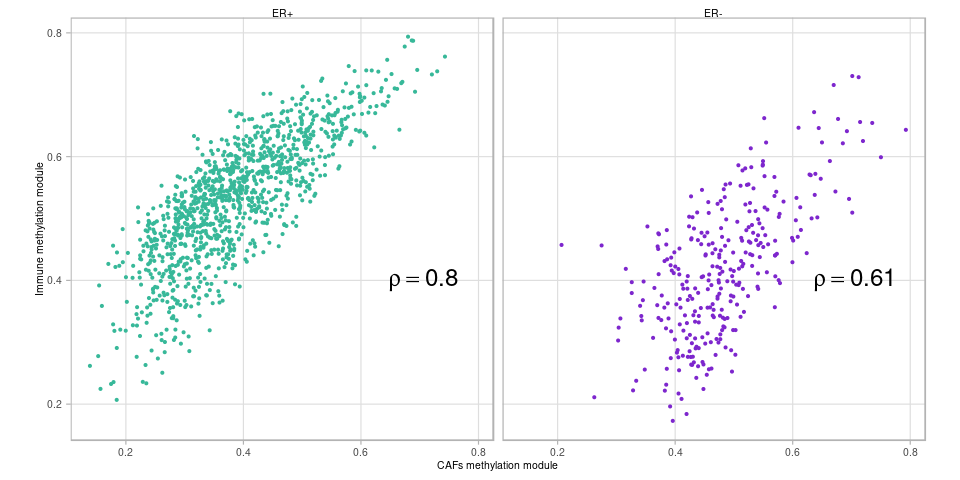

In [32]:
options(repr.plot.width = 8, repr.plot.height = 4)

df <- tme_df %>%         
    add_ER() %>% 
    filter(ER != "normal") %>%     
    as_tibble() 
    
rho_df <- df %>% 
    group_by(ER) %>% 
    summarise(rho = cor(caf.meth, immune.meth, use="pairwise.complete.obs", method="spearman")) %>% 
    mutate(label = sprintf("~rho == %0.2f", rho))


p_immune_caf <- df %>% 
    ggplot(aes(x=caf.meth, y=immune.meth, color=ER)) + 
        geom_point(size=0.1) + 
        scale_color_manual(values=annot_colors$ER1) + 
        theme(aspect.ratio=1) + 
        guides(color="none") + 
        facet_wrap(.~ER) + 
        xlab("CAFs methylation module") + 
        ylab("Immune methylation module")         

p_immune_caf + geom_text(data = rho_df, inherit.aes = FALSE, x = 0.7, y = 0.4, aes(label=label), parse=TRUE, size=5)

## Annotate TME scores

We reverse immune and CAF methylation scores so as higher score => more progressed. 

In [33]:
feats <- tme_df %>% mutate(immune.meth = -immune.meth, caf.meth = -caf.meth)

We will calculate the distribution of tumor grade stratified by five bins of Immune/CAF methylation scores:

In [34]:
nbins <- 5
df <- feats %>%     
    mutate(        
        immune = cut(immune, quantile(immune, 0:nbins/nbins, na.rm=TRUE), include.lowest=TRUE, labels=1:nbins), 
        caf = cut(caf, quantile(caf, 0:nbins/nbins, na.rm=TRUE), include.lowest=TRUE, labels=1:nbins), 
        immune.meth = cut(immune.meth, quantile(immune.meth, 0:nbins/nbins, na.rm=TRUE), include.lowest=TRUE, labels=1:nbins), 
        caf.meth = cut(caf.meth, quantile(caf.meth, 0:nbins/nbins, na.rm=TRUE), include.lowest=TRUE, labels=1:nbins)) %>% 
    left_join(samp_data %>% select(samp, ER=ER1, stage, grade), by = "samp") %>% 
    mutate(stage = ifelse(stage %in% c(0, "DCIS", 1), "0-1", stage)) %>% 
    mutate(stage = ifelse(ER == "normal", "N", stage)) %>% 
    mutate(grade = ifelse(ER == "normal", "N", grade))

Calculate p-values:

In [35]:
df %>% 
    filter(ER %in% c("ER+", "ER-")) %>% 
    gather("feat", "bin", -samp, -ER, -stage, -grade) %>% 
    group_by(ER, feat) %>% 
    summarise(grade_pval = chisq.test(bin, grade)$p.value, stage_pval = chisq.test(bin, stage)$p.value) %>%
    mutate(signif = case_when(grade_pval <= 0.0001 ~ "****", grade_pval <= 0.001 ~ "***", grade_pval <= 0.01 ~ "**", grade_pval <= 0.05 ~ "*")) %>% 
    as.data.frame()

Warning message in chisq.test(bin, grade):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, grade):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, grade):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, grade):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(bin, stage):
“Chi-squared approximation may be incorrect”


ER  feat        grade_pval    stage_pval  signif
1 ER- caf         0.00022642925 0.001946125 ***   
2 ER- caf.meth    0.00308191469 0.209690818 **    
3 ER- immune      0.37129150376 0.580276177 NA    
4 ER- immune.meth 0.30517904201 0.102242249 NA    
5 ER+ caf         0.00006512545 0.060334718 ****  
6 ER+ caf.meth    0.00001267372 0.070515621 ****  
7 ER+ immune      0.00063631960 0.457202009 ***   
8 ER+ immune.meth 0.00557962596 0.293001516 **

#### Figure 1g

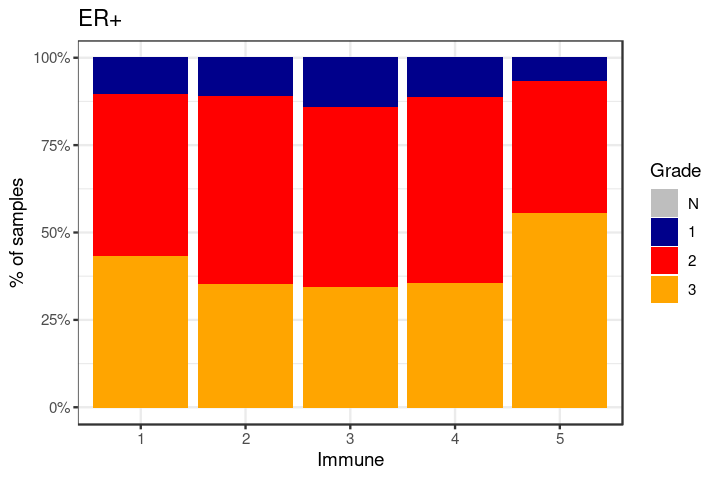

In [36]:
options(repr.plot.width = 6, repr.plot.height = 4)
p_grade_immune_positive <- df %>% 
    filter(ER == "ER+") %>% 
    mutate(grade = factor(grade, levels = c("N", "1", "2", "3"))) %>% 
    filter(!is.na(grade)) %>% 
    count(grade, immune.meth) %>% 
    group_by(immune.meth) %>% 
    mutate(p = n / sum(n)) %>% 
    ggplot(aes(x=immune.meth, y=p, fill=grade)) + 
        geom_col() + 
        scale_fill_manual(name = "Grade", values = c("N" = "gray", "1" = "darkblue", "2" = "red", "3" = "orange")) + 
        scale_y_continuous(labels=scales::percent) + 
        xlab("Immune") + 
        ylab("% of samples") + 
        ggtitle("ER+")
p_grade_immune_positive + theme_bw()

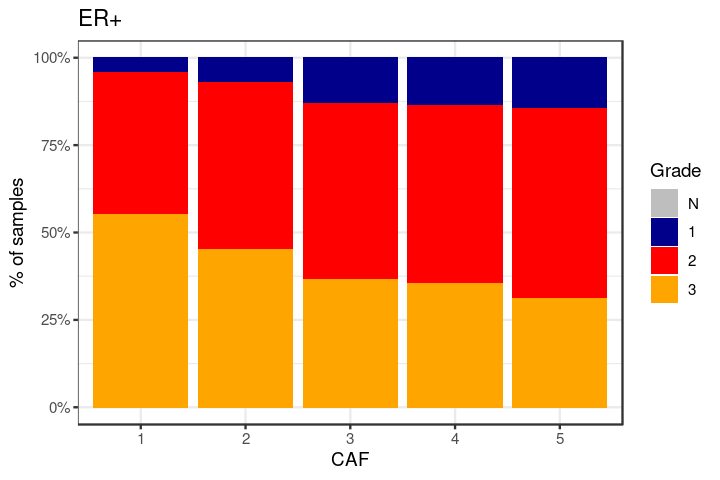

In [37]:
p_grade_caf_positive <- df %>% 
    filter(ER == "ER+") %>% 
    mutate(grade = factor(grade, levels = c("N", "1", "2", "3"))) %>% 
    filter(!is.na(grade)) %>% 
    count(grade, caf.meth) %>% 
    group_by(caf.meth) %>% 
    mutate(p = n / sum(n)) %>% 
    ggplot(aes(x=caf.meth, y=p, fill=grade)) + 
        geom_col() + 
        scale_fill_manual(name = "Grade", values = c("N" = "gray", "1" = "darkblue", "2" = "red", "3" = "orange")) + 
        scale_y_continuous(labels=scales::percent) + 
        ylab("% of samples") + 
        xlab("CAF") + 
        ggtitle("ER+")
p_grade_caf_positive + theme_bw()

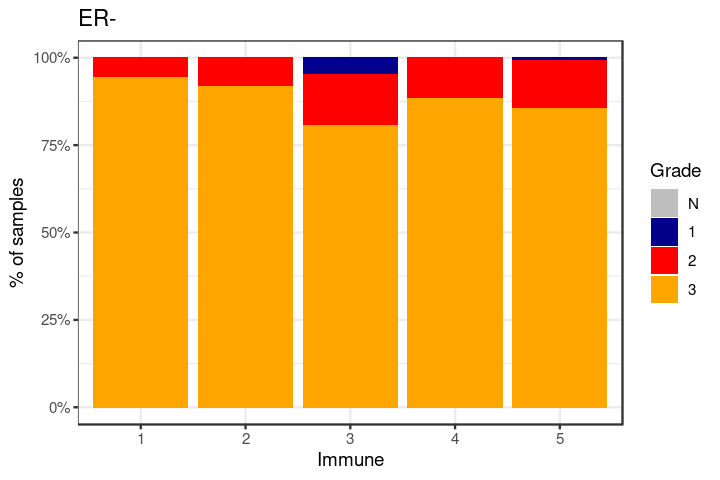

In [38]:
p_grade_immune_negative <- df %>% 
    filter(ER == "ER-") %>% 
    mutate(grade = factor(grade, levels = c("N", "1", "2", "3"))) %>% 
    filter(!is.na(grade)) %>% 
    count(grade, immune.meth) %>% 
    group_by(immune.meth) %>% 
    mutate(p = n / sum(n)) %>% 
    ggplot(aes(x=immune.meth, y=p, fill=grade)) + 
        geom_col() + 
        scale_fill_manual(name = "Grade", values = c("N" = "gray", "1" = "darkblue", "2" = "red", "3" = "orange")) + 
        scale_y_continuous(labels=scales::percent) + 
        ylab("% of samples") + 
        xlab("Immune") + 
        ggtitle("ER-")
p_grade_immune_negative + theme_bw()

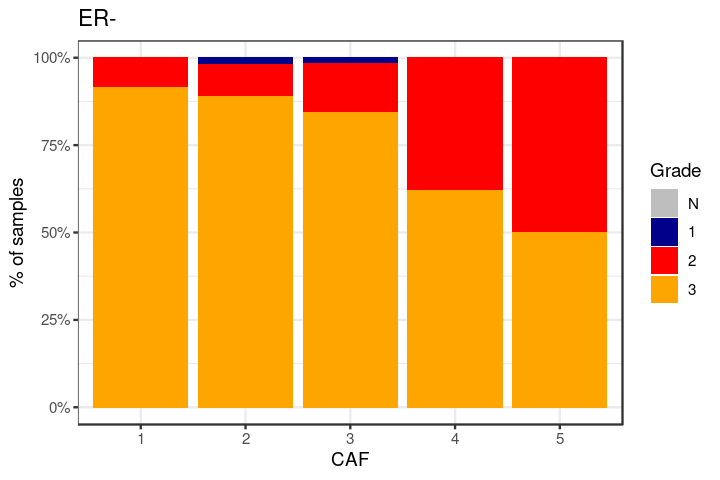

In [39]:
p_grade_caf_negative <- df %>% 
    filter(ER == "ER-") %>% 
    mutate(grade = factor(grade, levels = c("N", "1", "2", "3"))) %>% 
    filter(!is.na(grade)) %>% 
    count(grade, caf.meth) %>% 
    group_by(caf.meth) %>% 
    mutate(p = n / sum(n)) %>% 
    ggplot(aes(x=caf.meth, y=p, fill=grade)) + 
        geom_col() + 
        scale_fill_manual(name = "Grade", values = c("N" = "gray", "1" = "darkblue", "2" = "red", "3" = "orange")) + 
        scale_y_continuous(labels=scales::percent) + 
        ylab("% of samples") + 
        xlab("CAF") + 
        ggtitle("ER-")
p_grade_caf_negative + theme_bw()

## Appendix: Sensitivity analysis of TME normalization

#### Extended Data Figure 3e

In [40]:
get_TME_deconv_sensitivity <- function(prom_avg_meth, expr_mat, all_meth){
    {
        calc_tme_gene_cor <- function(samples, k, genes = c("CAV1", "CD3D", "TOP2A", "GATA3")){
            print(k)
            deconv_list <- deconv_TME_metabric(prom_avg_meth, all_meth, expr_mat, samples, k = k) 
            calc_gene_cor_before_after_deconv(deconv_list, all_meth, genes) %>% mutate(k = k)
        }

        ER_pos_df <- map_dfr(seq(5,60,5), ~ calc_tme_gene_cor(ER_positive_samples, .x) %>% mutate(ER = "ER+"))
        ER_neg_df <- map_dfr(seq(5,60,5), ~ calc_tme_gene_cor(ER_negative_samples, .x) %>% mutate(ER = "ER-"))
        normal_df <- map_dfr(seq(5,60,5), ~ calc_tme_gene_cor(normal_samples, .x) %>% mutate(ER = "normal+"))

        sens_df <- bind_rows(ER_pos_df, ER_neg_df, normal_df)
        sens_df 
    } %cache_df% here("data/TME_sensetivity.tsv") %>% as_tibble()
}

In [42]:
sens_df <- get_TME_deconv_sensitivity(prom_avg_meth, expr_mat, all_meth) %>% mutate(ER = factor(ER, levels = c("ER+", "ER-", "normal")))

[1] 5


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 10


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 15


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 20


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 25


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 30


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 35


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 40


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 45


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 50


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 55


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 60


min_sd: 0.0965215274820842

min_expr: 6.00725469829817

calculating em-cross

# of samples: 1108

expression (columns): 16806

methylation (rows): 3946

2701 rows had at least one cor > 0.25

5879 columns had at least one cor > 0.25

5879 columns did not have more than 0 Na's 

2701 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 2

cafs module: 8

calculating TME methylation scores



[1] 5


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 10


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 15


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 20


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 25


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 30


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 35


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 40


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 45


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 50


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 55


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 60


min_sd: 0.0963502916561555

min_expr: 6.00725469829817

calculating em-cross

# of samples: 310

expression (columns): 16806

methylation (rows): 3684

3525 rows had at least one cor > 0.25

11054 columns had at least one cor > 0.25

11054 columns did not have more than 0 Na's 

3525 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 16

cafs module: 18

calculating TME methylation scores



[1] 5


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 10


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 15


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 20


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 25


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 30


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 35


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 40


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 45


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 50


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 55


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



[1] 60


min_sd: 0.0656269964434713

min_expr: 6.00725469829817

calculating em-cross

# of samples: 92

expression (columns): 16806

methylation (rows): 2636

2636 rows had at least one cor > 0.25

16806 columns had at least one cor > 0.25

16806 columns did not have more than 0 Na's 

2636 rows did not have more than 0 Na's 

clustering em-cross

normalizing methylation

immune module: 3

cafs module: 11

calculating TME methylation scores



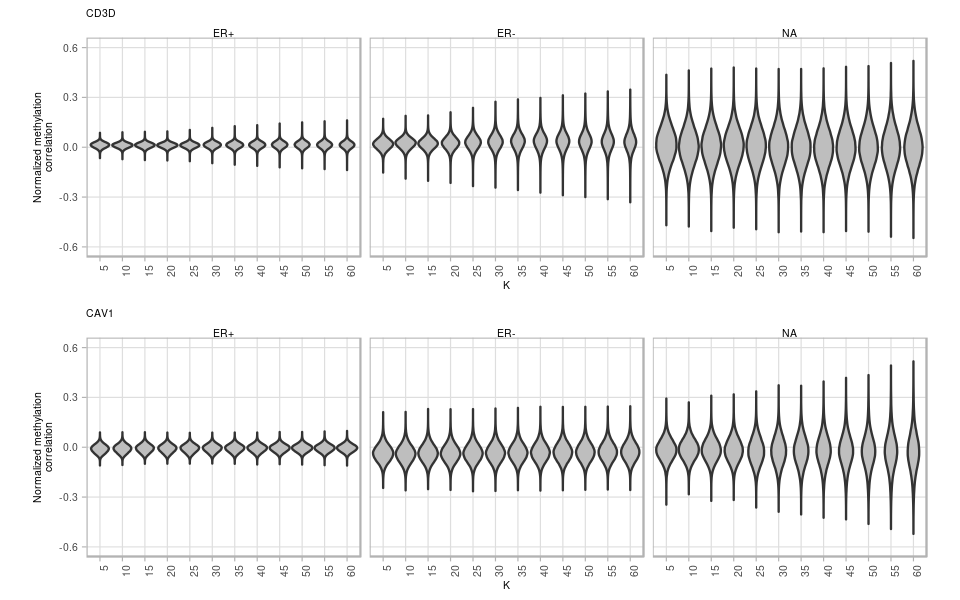

In [43]:
options(repr.plot.width = 8, repr.plot.height = 5)
CD3D_plot <- sens_df %>% 
    mutate(cor = CD3D.norm) %>% 
    ggplot(aes(x=factor(k), y=cor)) + 
        geom_violin(fill="gray") + 
        ggtitle("CD3D") + 
        xlab("K") + 
        ylab("Normalized methylation\ncorrelation") + 
        facet_grid(.~ER) + 
        ylim(-0.6, 0.6) + 
        theme(aspect.ratio=0.8) + 
        vertical_labs()
CAV_plot <- sens_df %>% 
        mutate(cor = CAV1.norm) %>% 
        ggplot(aes(x=factor(k), y=cor)) + 
            geom_violin(fill="gray") + 
            ggtitle("CAV1") + 
            xlab("K") + 
            ylab("Normalized methylation\ncorrelation") + facet_grid(.~ER) + ylim(-0.6, 0.6) + theme(aspect.ratio=0.8) + vertical_labs()

p_sens <- cowplot::plot_grid(CD3D_plot, CAV_plot, nrow=2, align = "hv")
p_sens

We can see that larger values of K lead to less effective normalization (wider correlation distribution) of the CAF and immune signatures since the neighborhood becomes less homogenous in the Immune/CAF space. 

In [ ]:
gc()